# Маркетинг
Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов необходимо выделить пользователей,
которые готовы совершить покупку в ближайшее время.  
Требуется предсказать вероятность покупки в течение 90 дней пользователем интернет-магазина. Заказчиком определена метрика требуемой модели: ROC AUC >= 0.7.  
Интернет-магазин предоставил данные об истории покупок и истории рекламных рассылок.  
Описание данных:
1. apparel-purchases - информация о покупках:
 - client_id идентификатор клиента
 - quantity количество единиц товара
 - price цена товара
 - category_ids идентификаторы категорий
 - date дата покупки
 - message_id идентификатор сообщения из рассылки
2. apparel-messages - информация о рассылках:
 - bulk_campaign_id идентификатор рассылки
 - client_id идентификатор клиента
 - message_id идентификатор сообщения
 - event действие с сообщением
 - channel канал рассылки
 - date дата действия
 - created_at дата-время полностью
3. apparel-target_binary - информация о факте повторной покупки:
 - client_id идентификатор клиента
 - target клиент совершил покупку в целевом периоде  

Исследование проходит в несколько этапов:
1. Загрузка данных.
2. Анализ данных.
3. Разработка признаков.
4. Обучение модели.
5. Оценка значимости признаков.

## Загрузка данных

Импорт необходимых библиотек и модулей:

In [1]:
!pip install phik

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
import shap
import ast
from phik import phik_matrix
from google.colab import drive

TEST_SIZE = 0.25
RANDOM_STATE = 42

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Монтирование Google Drive с исходными данными:

In [3]:
drive.mount('/content/gdrive');

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Загрузка исходных данных в датафреймы:

In [4]:
apparel_messages = pd.read_csv('/content/gdrive/MyDrive/apparel-messages.csv', parse_dates = ['date', 'created_at'])
apparel_messages.Name = 'apparel_messages'

apparel_purchases = pd.read_csv('/content/gdrive/MyDrive/apparel-purchases.csv', parse_dates=['date'])
apparel_purchases.Name = 'apparel_purchases'

apparel_target = pd.read_csv('/content/gdrive/MyDrive/apparel-target_binary.csv')
apparel_target.Name = 'apparel_target'

Вывод общей информации об исходных данных:

In [5]:
for df in [apparel_messages, apparel_purchases, apparel_target]:
  print(f'Датафрейм {df.Name}:')
  df.info()
  display(df.head())
  print('\n\n\n')

Датафрейм apparel_messages:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52






Датафрейм apparel_purchases:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843






Датафрейм apparel_target:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


Все столбцы имеют корректные типы данных. Для признаков event и channel датафрейма apparel_messages выполним проверку на наличие опечаток:

In [6]:
for column in ['event', 'channel']:
    print(f'Уникальные значения в столбце {str(column)}:')
    print(apparel_messages[column].sort_values().unique(), '\n')

Уникальные значения в столбце event:
['click' 'close' 'complain' 'hard_bounce' 'hbq_spam' 'open' 'purchase'
 'send' 'soft_bounce' 'subscribe' 'unsubscribe'] 

Уникальные значения в столбце channel:
['email' 'mobile_push'] 



Опечаток не обнаружено.

Также проверим на корректность данные в category_ids датафрейма apparel_purchases:

In [7]:
print(apparel_purchases['category_ids'].sort_values().unique())

["['1', '22', '50', '685']" "['1', '8', '280', '710']"
 "['2', '17', '107', '453']" "['2', '17', '137', '469']"
 "['2', '17', '171', '475']" "['2', '17', '173', '1598']"
 "['2', '17', '173', '1845']" "['2', '17', '173', '459']"
 "['2', '17', '180', '465']" "['2', '17', '1826', '1818']"
 "['2', '17', '188', '525']" "['2', '17', '198', '497']"
 "['2', '17', '232', '463']" "['2', '17', '279', '5807']"
 "['2', '17', '286', '455']" "['2', '17', '293', '5819']"
 "['2', '17', '330', '387', '467']" "['2', '17', '83', '519']"
 "['2', '17', '83', '5810']" "['2', '18', '123', '451']"
 "['2', '18', '155', '1325']" "['2', '18', '155', '439']"
 "['2', '18', '212', '658']" "['2', '18', '212', '659']"
 "['2', '18', '212', '726']" "['2', '18', '217', '662']"
 "['2', '18', '217', '663']" "['2', '18', '243', '440']"
 "['2', '18', '248', '449']" "['2', '18', '248', '677']"
 "['2', '18', '258', '1195']" "['2', '18', '258', '1561']"
 "['2', '18', '258', '1562']" "['2', '18', '258', '1569']"
 "['2', '18', '2

Обнаружены некорректные данные: '[None]' и '[]'.

In [8]:
print('Строчек с "[]":', apparel_purchases.loc[apparel_purchases['category_ids'] == '[]'].shape[0])
print('Строчек с "[None]":', apparel_purchases.loc[apparel_purchases['category_ids'] == '[None]'].shape[0])
print('Доля некорректных записей:', (apparel_purchases.loc[apparel_purchases['category_ids'] == '[]'].shape[0] + \
      apparel_purchases.loc[apparel_purchases['category_ids'] == '[None]'].shape[0]) / apparel_purchases.shape[0])

Строчек с "[]": 5579
Строчек с "[None]": 1264
Доля некорректных записей: 0.03384139104288653


Таких записей около 3% процентов от общего количества, от них можно отказаться:

In [9]:
apparel_purchases = apparel_purchases.loc[apparel_purchases['category_ids'] != '[]']
apparel_purchases = apparel_purchases.loc[apparel_purchases['category_ids'] != '[None]']
apparel_purchases.Name = 'apparel_purchases'
print('Строчек с "[]":', apparel_purchases.loc[apparel_purchases['category_ids'] == '[]'].shape[0])
print('Строчек с "[None]":', apparel_purchases.loc[apparel_purchases['category_ids'] == '[None]'].shape[0])
print('Доля некорректных записей:', (apparel_purchases.loc[apparel_purchases['category_ids'] == '[]'].shape[0] + \
      apparel_purchases.loc[apparel_purchases['category_ids'] == '[None]'].shape[0]) / apparel_purchases.shape[0])

Строчек с "[]": 0
Строчек с "[None]": 0
Доля некорректных записей: 0.0


В датафреймах apparel_purchases и apparel_target пропуски отсутствуют. Необходимо проверить наличие таковых в apparel_messages:



In [10]:
apparel_messages.isnull().sum()

,0
bulk_campaign_id,0
client_id,0
message_id,0
event,0
channel,0
date,0
created_at,0


Пропуски в данных отсутствуют. Необходимо проверить наличие дубликатов:

In [11]:
for df in [apparel_messages, apparel_purchases, apparel_target]:
  print(f'Дубликатов в {df.Name}: {df.duplicated().sum()}')

Дубликатов в apparel_messages: 48610
Дубликатов в apparel_purchases: 69537
Дубликатов в apparel_target: 0


Обнаружены дубликаты в датафреймах apparel_messages и apparel_purchases. В случае с apparel_messages в данных присутствуют временные метки создания сообщения вплоть до секунд. Это значит, что дубликаты, обнаруженные в apparel_messages, действительно являются задублированными записями, указывающими на одну и т уже сущность (событие). От таких дубликатов следует отказаться:

In [12]:
apparel_messages = apparel_messages.drop_duplicates()
apparel_messages.duplicated().sum()

0

Дубликаты в apparel_messages удалены.  
Для apparel_purchases ситуация иная: там нет достаточно точных временных меток, по которым можно было бы сделать вывод о дублировании записей, отражающих одно и то же событие. Кроме того, дубликатов в apparel_purchases очень много: 73020 из 202208 записей, это больше трети. Это наводит на мысль о том, что такие записи отражают разные покупки, и удалять эти данные нельзя.

### Выводы по первому этапу
1. Импортированы необходимые библиотеки и модули.
2. Исходные данные загружены в датафреймы pandas.
3. Получена общая информация о данных.
4. Проведена проверка наличия в данных пропусков, опечаток и дубликатов.
5. Устранены некорректные значения в столбце category_ids датафрейма apparel_purchases.
6. Устранены дубликаты в датафрейме apparel_messages.

## Анализ данных

Определение вспомогательных функций:

In [13]:
def plot_num_features(df):
    for column in df.columns:
        plt.figure(figsize = (10, 10))
        # Гистограмма
        data = df[column]
        plt.subplot(2,1,1)
        plt.hist(data, histtype='bar')
        plt.xlabel(column)
        plt.ylabel('Частота встречаемости')
        plt.title(f'Распределение признака {column}')
        # Диаграмма размаха
        plt.subplot(2,1,2)
        plt.boxplot(data, vert = False)
        plt.ylabel(f'Диаграмма размаха {column}')
        plt.xlabel(column)
        plt.show()
        print(f'Среднее значение признака {column}: {data.mean():.2f}')
        print(f'Медианное значение признака {column}: {data.median():.2f}')
        print('\n\n\n')



def plot_cat_features(df):
    for column in df.columns:
        print(f'Нормализованное распределение признака {column}:')
        print(df[column].value_counts(normalize = True))
        ax = df[column].value_counts().plot(kind = 'bar', figsize = (10, 6))
        ax.set_xlabel(column)
        ax.set_ylabel('Частота встречаемости')
        ax.set_title(f'График распределения признака {column}')
        plt.show()
        print('\n\n')

Анализ признаков в apparel_messages:

Нормализованное распределение признака event:
event
send           7.137373e-01
open           2.405197e-01
click          3.808359e-02
purchase       4.932005e-03
hard_bounce    1.557222e-03
soft_bounce    8.338069e-04
unsubscribe    2.232258e-04
hbq_spam       6.484815e-05
complain       4.152488e-05
subscribe      6.697561e-06
close          7.879483e-08
Name: proportion, dtype: float64


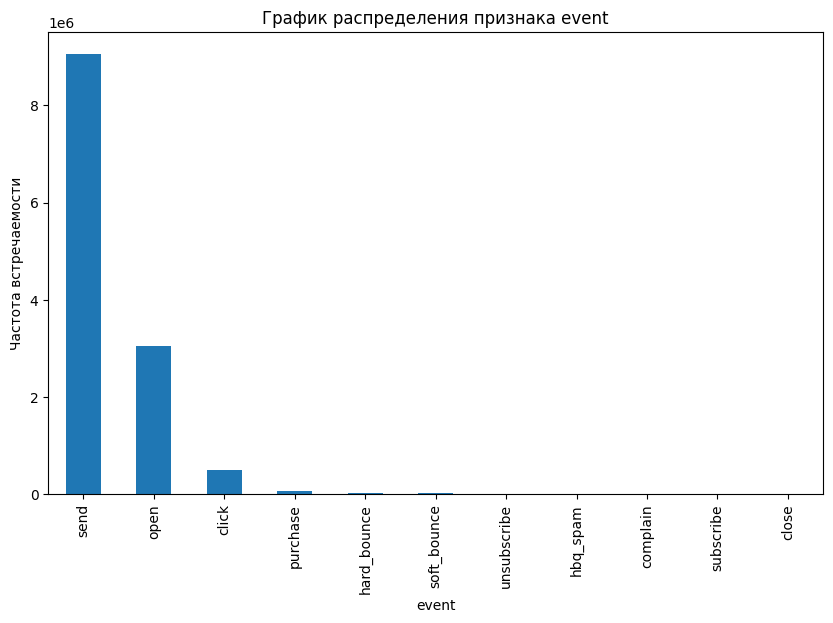




Нормализованное распределение признака channel:
channel
mobile_push    0.588635
email          0.411365
Name: proportion, dtype: float64


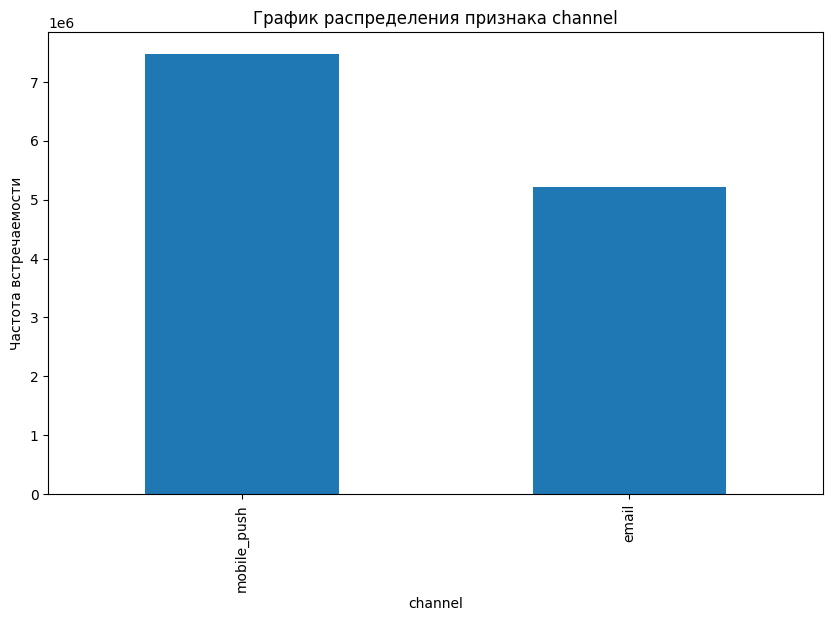

In [14]:
cat_features = ['event', 'channel']
plot_cat_features(apparel_messages[cat_features])

Пуш-уведомления рассылают чаще, чем сообщения электронной почты: 59% против 41% соответственно. Доля рассылок, приводящих к покупке, составляет около 0.5%

Анализ признаков в apparel_purchases:

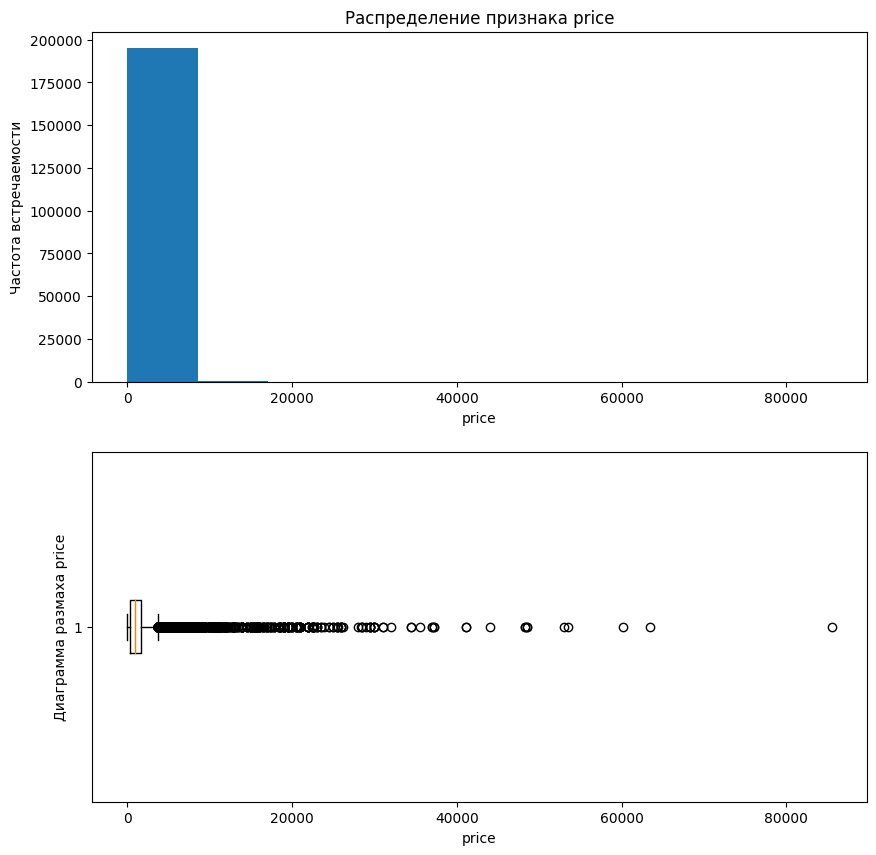

Среднее значение признака price: 1233.40
Медианное значение признака price: 999.00






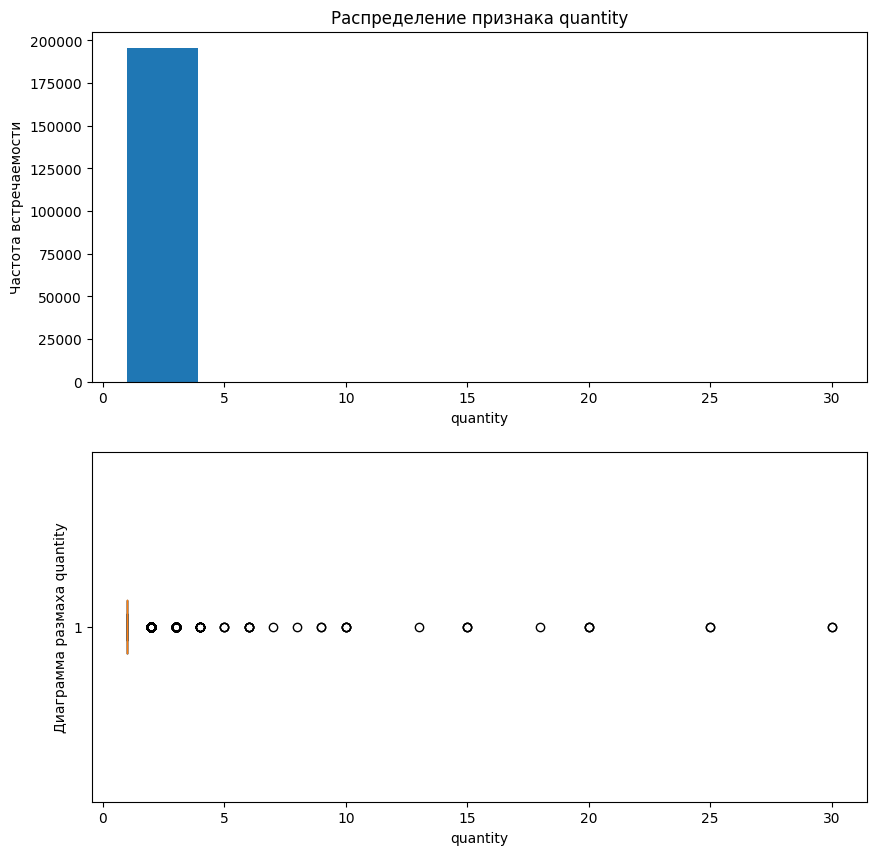

Среднее значение признака quantity: 1.01
Медианное значение признака quantity: 1.00






In [15]:
num_features = ['price', 'quantity']
plot_num_features(apparel_purchases[num_features])

Средняя стоимость покупок составляет около 1000. Для большинства покупок характерно количество единиц товара равное одному:

In [16]:
apparel_purchases.loc[apparel_purchases['quantity'] == 1].shape[0] / apparel_purchases.shape[0]

0.9954700176592532

Доля таких 'одиночных' покупок составляет более 99%. возможно, при покупке даже нескольких единиц товара система интернет-магазина обрабатывает такие покупки по одной.

Анализ признака в apparel_target:

Нормализованное распределение признака target:
target
0    0.980722
1    0.019278
Name: proportion, dtype: float64


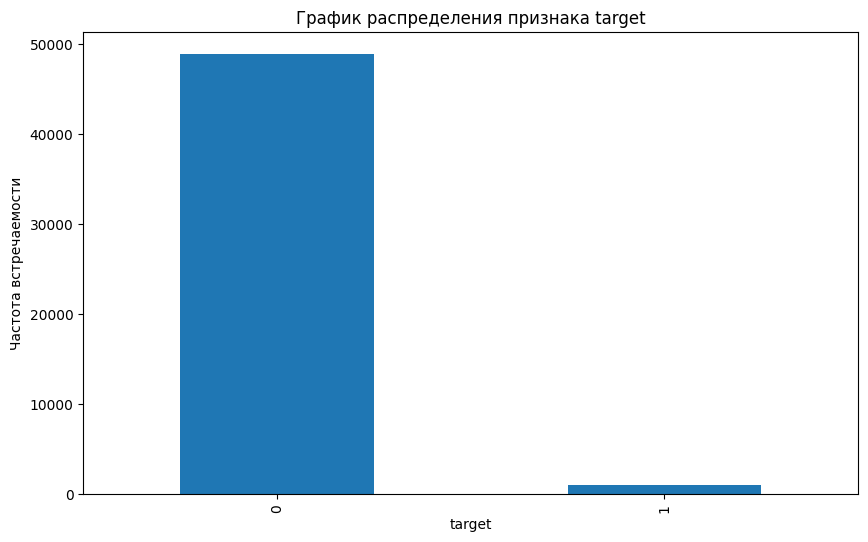

In [17]:
cat_features = ['target']
plot_cat_features(apparel_target[cat_features])

Наблюдается сильный дисбаланс классов по целевому признаку: повторную покупки совершили менее 2% клиентов интернет-магазина. При разбиении данных на обучающую и тестовую выборки необходимо применить стратификацию.

### Выводы по второму этапу
В результате анализа данных установлено, что:
1. Пуш-уведомления рассылают немного чаще, чем сообщения электронной почты. Доля рассылок, приводящих к покупке, составляет около 0.5%.
2. Средняя стоимость покупок составляет около 1000. Для большинства покупок характерно количество единиц товара равное одному.
3. Повторную покупки совершили менее 2% клиентов интернет-магазина.

## Разработка признаков

### Выбор новых признаков

Подсчет количества совершенных покупок для каждого пользователя:

In [18]:
purchases_count = apparel_purchases.groupby(by = 'client_id')['price'].count()
purchases_count = purchases_count.rename('orders_count')
purchases_count.head()

,orders_count
client_id,
1515915625468060902,7
1515915625468061003,7
1515915625468061099,1
1515915625468061100,2
1515915625468061170,17


Подсчет количества денег, которые потратил пользователь за период анализа:

In [19]:
apparel_purchases['orders_sum'] = apparel_purchases['quantity'] * apparel_purchases['price']
pyrchases_sum = apparel_purchases.groupby(by = 'client_id')['orders_sum'].sum()
apparel_purchases = apparel_purchases.drop('orders_sum', axis = 1)
pyrchases_sum.head()

,orders_sum
client_id,
1515915625468060902,6993.0
1515915625468061003,16235.0
1515915625468061099,299.0
1515915625468061100,2098.0
1515915625468061170,33587.0


Расчет средней цены товаров, которые покупал пользователь:

In [20]:
mean_price = apparel_purchases.groupby(by = 'client_id')['price'].mean()
mean_price = mean_price.rename('mean_price')
mean_price.head()

,mean_price
client_id,
1515915625468060902,999.000000
1515915625468061003,2319.285714
1515915625468061099,299.000000
1515915625468061100,1049.000000
1515915625468061170,1975.705882


Расчет среднего количества товаров, которые покупал пользователь:

In [21]:
mean_quantity = apparel_purchases.groupby(by = 'client_id')['quantity'].mean()
mean_quantity = mean_quantity.rename('mean_quantity')
mean_quantity.head()

,mean_quantity
client_id,
1515915625468060902,1.0
1515915625468061003,1.0
1515915625468061099,1.0
1515915625468061100,1.0
1515915625468061170,1.0


### Объединение таблиц

Объединение с pyrchases_sum:

In [22]:
apparel_purchases = apparel_purchases.join(pyrchases_sum, on = 'client_id')

Объединение с purchases_count:

In [23]:
apparel_purchases = apparel_purchases.join(purchases_count, on ='client_id', rsuffix='_count')

Объединение с mean_quantity:

In [24]:
apparel_purchases = apparel_purchases.merge(mean_quantity, on='client_id')

Объединение с mean_price:

In [25]:
apparel_purchases = apparel_purchases.merge(mean_price, on='client_id')

Объединение с apparel_target:

In [26]:
apparel_purchases = apparel_purchases.merge(apparel_target, on='client_id')

Удаление неинформативных признаков:

In [27]:
apparel_purchases = apparel_purchases.drop(['category_ids', 'date', 'message_id', 'client_id'], axis = 1)

Итоговый датафрейм для исследования:

In [28]:
display(apparel_purchases.head())
apparel_purchases.info()

,quantity,price,orders_sum,orders_count,mean_quantity,mean_price,target
0,1,1999.0,23612.0,9,1.0,2623.555556,0
1,1,2499.0,23612.0,9,1.0,2623.555556,0
2,1,6499.0,16497.0,3,1.0,5499.000000,0
3,1,4999.0,16497.0,3,1.0,5499.000000,0
4,1,4999.0,16497.0,3,1.0,5499.000000,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195365 entries, 0 to 195364
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   quantity       195365 non-null  int64  
 1   price          195365 non-null  float64
 2   orders_sum     195365 non-null  float64
 3   orders_count   195365 non-null  int64  
 4   mean_quantity  195365 non-null  float64
 5   mean_price     195365 non-null  float64
 6   target         195365 non-null  int64  
dtypes: float64(4), int64(3)
memory usage: 10.4 MB


### Корреляционный анализ

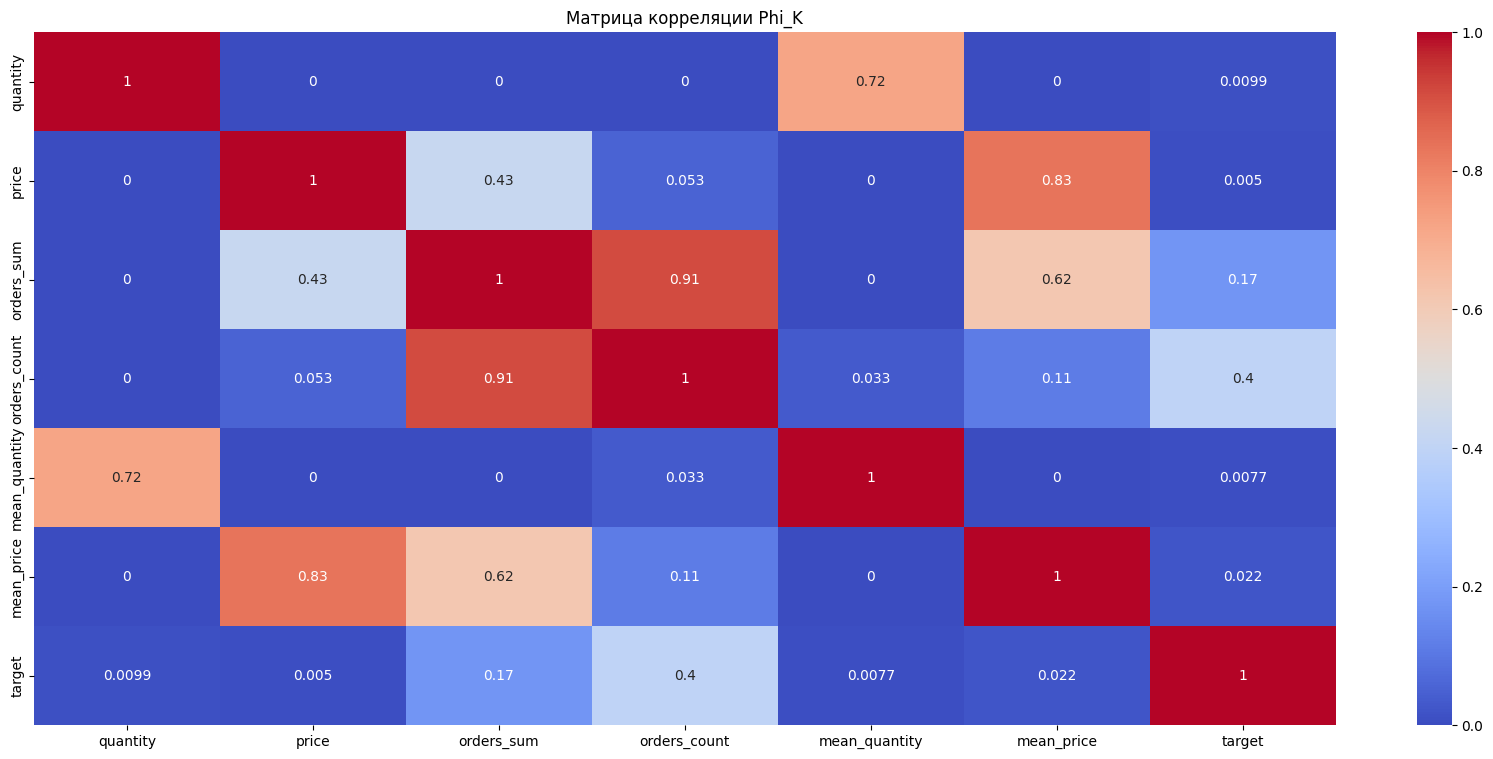

In [29]:
corr_matrix = apparel_purchases.phik_matrix(interval_cols = ['mean_quantity', 'mean_price', 'orders_sum', 'order_count', 'quantity', 'price'])
plt.figure(figsize=(21, 9))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции Phi_K')
plt.show()

Наблюдается высокий коэффициент корреляции между двумя синтетическими признаками: количеством покупок (orders_count) и суммой потраченных денег (orders_sum), что логично. Однако величина коэффициента меньше 0.95, поэтому оба признака будут участвовать в обучении модели. Наибольшую связь с целевым признаком (хоть и не сильную) показывает синтетический признак количества покупок (orders_count).

### Выводы по третьему этапу
1. На основе имеющихся данных разработаны новые признаки:  
- количество покупок для каждого пользователя;
- общее количество денег, которые потратил пользователь;
- средняя цена товаров, которые купил пользователь;
- среднее количество товаров, которые покупал пользователь.
2. Новые признаки добавлены в датафрейм apparel_purchases, оттуда же удалены неинформативные признаки.
3. Произведен корреляционный анализ данных. Установлено, что наиболее выраженную связь с целевым признаком имеет количество покупок пользователя.

## Обучение модели

Разбиение данных на обучающую и тестовые выборки:

In [30]:
features_train, features_test, target_train, target_test = train_test_split(
    apparel_purchases.drop(['target'], axis=1),
    apparel_purchases['target'],
    stratify = apparel_purchases['target'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE)

Построение пайплайна для обучения модели градиентного бустинга:

In [31]:
pipe_final = Pipeline([
    ('models', lgb.LGBMClassifier(random_state=RANDOM_STATE))
])

Параметры перебора в GridSearchCV:

In [32]:
params = {
    'models__n_estimators': [200, 400, 600, 800]
}

grid = GridSearchCV(pipe_final,
                    param_grid = params,
                    scoring='roc_auc',
                    cv=5,
                    n_jobs=-1)

Обучение модели на тренировочной выборке:

In [33]:
grid.fit(features_train, target_train);

[LightGBM] [Info] Number of positive: 4968, number of negative: 141555
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 942
[LightGBM] [Info] Number of data points in the train set: 146523, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033906 -> initscore=-3.349671
[LightGBM] [Info] Start training from score -3.349671


Параметры лучшей модели:

In [34]:
print('Лучшая модель и её параметры:\n', grid.best_estimator_)

Лучшая модель и её параметры:
 Pipeline(steps=[('models', LGBMClassifier(n_estimators=800, random_state=42))])


In [35]:
print (f'Метрика лучшей модели на тренировочной выборке: {grid.best_score_:.5f}')

Метрика лучшей модели на тренировочной выборке: 0.93353


Предсказание лучшей модели на тестовых данных:

In [36]:
test_target_pred = grid.predict(features_test)

In [37]:
print(f'Метрика ROC AUC на тестовой выборке: \
{roc_auc_score(target_test, test_target_pred)}')

Метрика ROC AUC на тестовой выборке: 0.7551380844355088


### Выводы по четвертому этапу
1. Осуществлено разбиение данных на тренировочную и тестовую выборки.
2. Построен папйлайн для обучения модели.
3. Осуществлен поиск оптимальных параметров модели градиентного бустинга в GridSearchCV по метрике ROC AUC.
4. На обучающей выборке метрика лучшей модели составила 0.93, на тестовой - 0.75. Данные значения являются для заказчика приемлемыми.

## Оценка значимости признаков

100%|===================| 146471/146523 [37:07<00:00]       

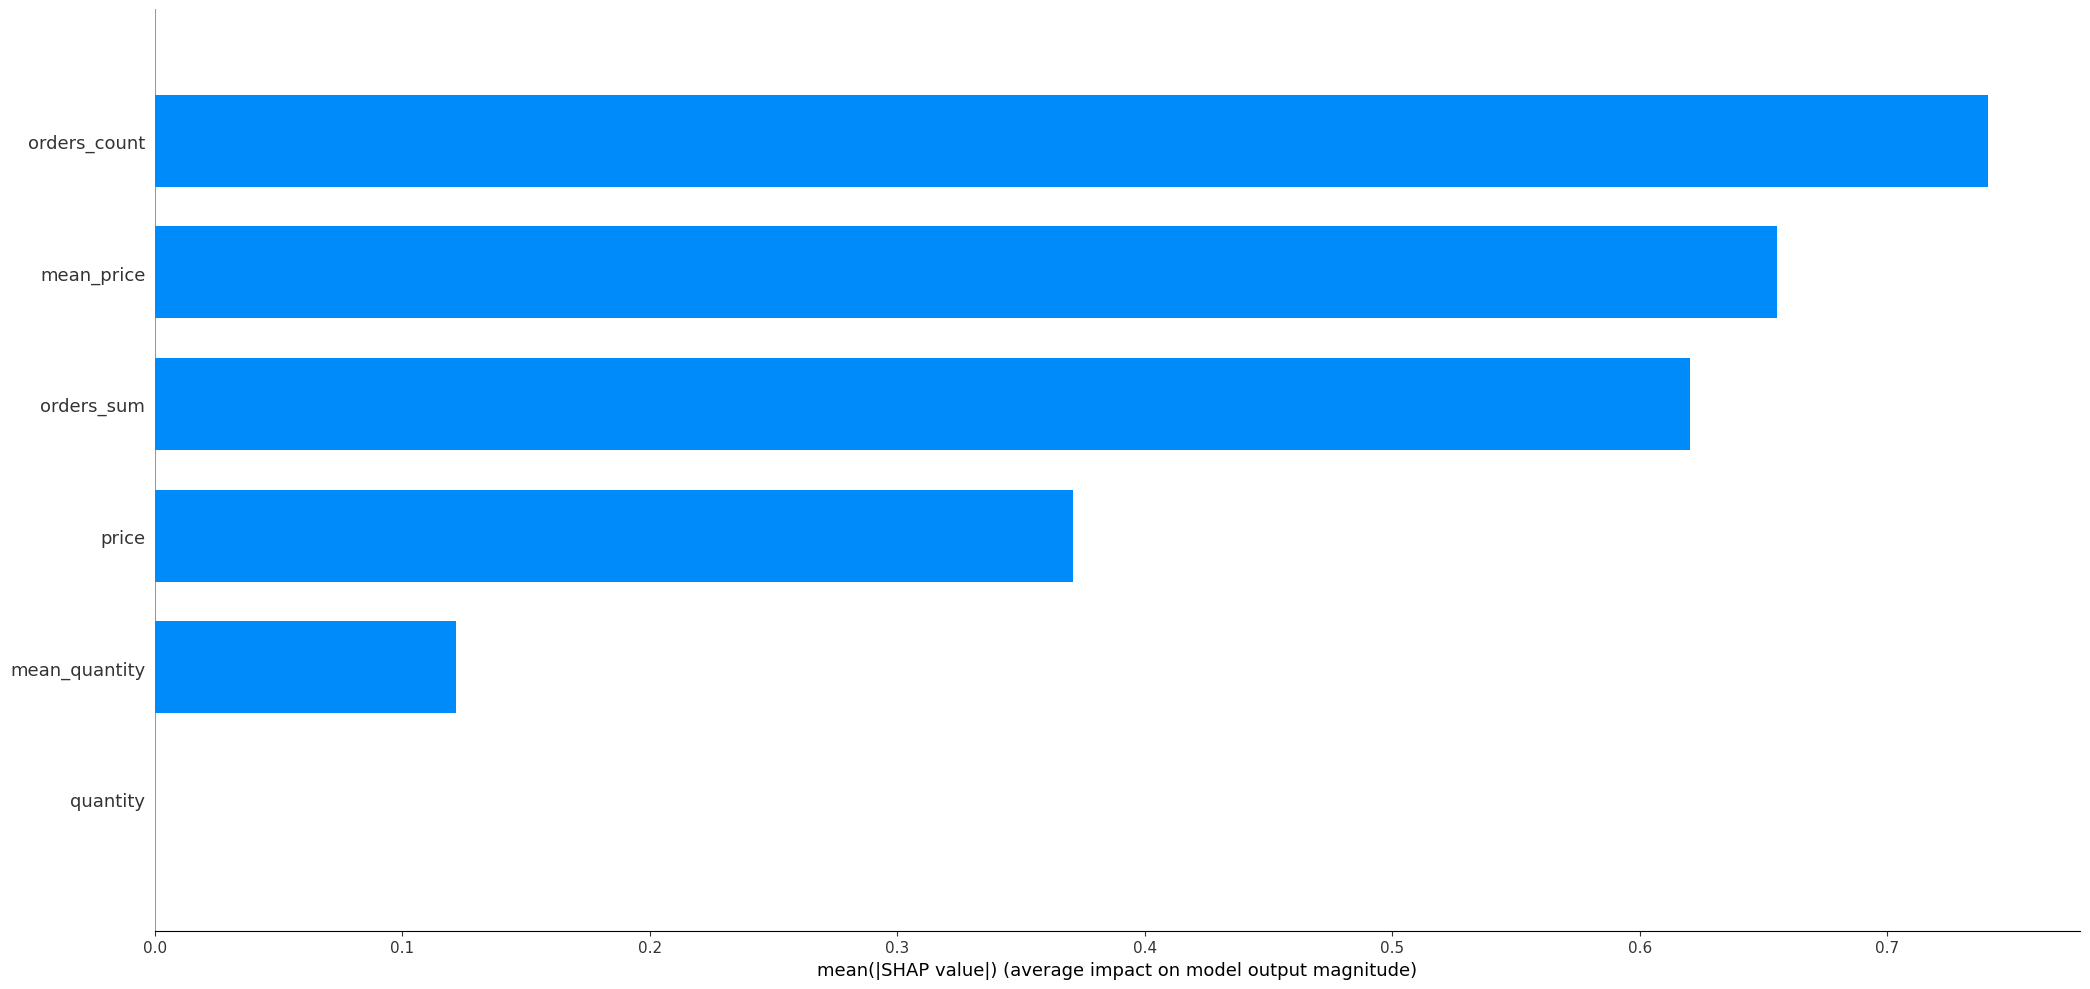

In [38]:
explainer = shap.TreeExplainer(grid.best_estimator_.named_steps['models'], features_train)
shap_values = explainer(features_train)
shap.summary_plot(shap_values, plot_type = 'bar', plot_size = (21, 10))

Наибольшее влияние на целевой оказывают такие признаки, как количество сделанных пользователем покупок, сумма потраченных пользователем денег и средняя цена товаров, купленных пользователем. Наименьшее влияние имеет количество единиц товрара в заказе.

## Выводы по исследованию
Было проведено исследование данных, предоставленных интернет-магазином. Для оптимизации процессов было необходимо выделить пользователей, которые готовы совершить покупку в ближайшее время.
Ислледование было проведено в несколько этапов:
1. Загрузка данных:
- импортированы необходимые библиотеки и модули;
- исходные данные загружены в датафреймы pandas;
- получена общая информация о данных;
- проведена проверка наличия в данных пропусков, опечаток и дубликатов;
- устранены некорректные значения в столбце category_ids датафрейма apparel_purchases;
- устранены дубликаты в датафрейме apparel_messages.
2. Анализ данных. Установлено, что:
- пуш-уведомления рассылают немного чаще, чем сообщения электронной почты. Доля рассылок, приводящих к покупке, составляет около 0.5%;
- средняя стоимость покупок составляет около 1000. Для большинства покупок характерно количество единиц товара равное одному;
- повторную покупки совершили менее 2% клиентов интернет-магазина.
3. Разработка признаков. На основе имеющихся данных разработаны новые признаки:  
- количество покупок для каждого пользователя;
- общее количество денег, которые потратил пользователь;
- средняя цена товаров, которые купил пользователь;
- среднее количество товаров, которые покупал пользователь.  
Новые признаки добавлены в датафрейм apparel_purchases, оттуда же удалены неинформативные признаки.  
Произведен корреляционный анализ данных. Установлено, что наиболее выраженную связь с целевым признаком имеет количество покупок пользователя.
4. Обучение модели:
- осуществлено разбиение данных на тренировочную и тестовую выборки;
- построен папйлайн для обучения модели;
- осуществлен поиск оптимальных параметров модели градиентного бустинга в GridSearchCV по метрике ROC AUC;
- на обучающей выборке метрика лучшей модели составила 0.93, на тестовой - 0.75.
5. Оценка значимости признаков. Установлено, что наибольшее влияние на целевой оказывают такие признаки, как количество сделанных пользователем покупок, сумма потраченных пользователем денег и средняя цена товаров, купленных пользователем.